# Project: IoT Sensor Time Series Anomaly Detection

**Objective:** Detect anomalous sensor readings indicating possible equipment failure or maintenance needs.

**Dataset:** `art_daily_jumpsup.csv`  timestamp + value.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [52]:
df=pd.read_csv('/kaggle/input/anomaly-detection/art_daily_jumpsup.csv')

In [53]:
df

,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739
...,...,...
4027,2014-04-14 23:35:00,18.074649
4028,2014-04-14 23:40:00,21.002014
4029,2014-04-14 23:45:00,20.566713
4030,2014-04-14 23:50:00,18.254193


In [54]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst few rows:\n", df.head())

Shape: (4032, 2)

Columns: ['timestamp', 'value']

Data types:
 timestamp     object
value        float64
dtype: object

First few rows:
              timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


In [55]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [56]:
df

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


In [57]:
df.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


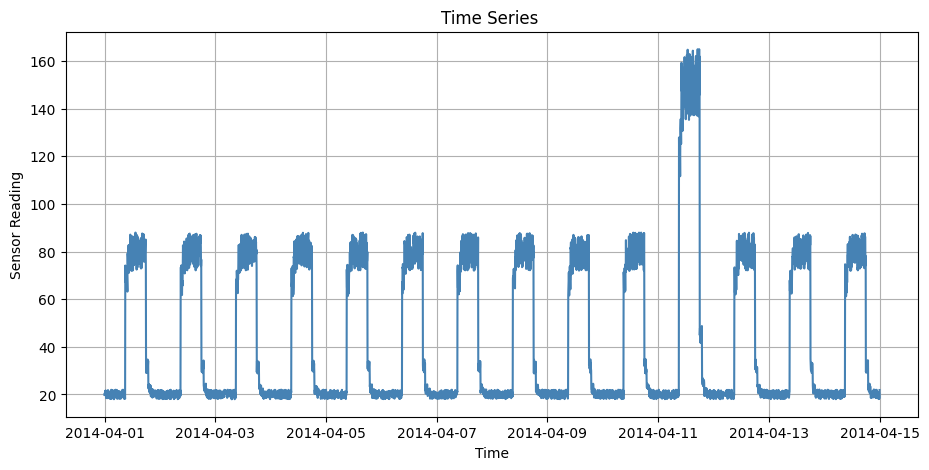

In [58]:
plt.figure(figsize=(11,5))
plt.plot(df.index, df['value'], color='steelblue')
plt.title("Time Series ")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.grid(True)
plt.show()

In [59]:
df.isnull().sum()

value    0
dtype: int64

In [60]:
z_scores=((df['value']-df['value'].mean())/df['value'].std())

In [61]:
z_scores

timestamp
2014-04-01 00:00:00   -0.762600
2014-04-01 00:05:00   -0.739796
2014-04-01 00:10:00   -0.756421
2014-04-01 00:15:00   -0.709289
2014-04-01 00:20:00   -0.749450
                         ...   
2014-04-14 23:35:00   -0.814603
2014-04-14 23:40:00   -0.724343
2014-04-14 23:45:00   -0.737765
2014-04-14 23:50:00   -0.809068
2014-04-14 23:55:00   -0.697792
Name: value, Length: 4032, dtype: float64

In [62]:
outliers = df[np.abs(z_scores) > 3]
outliers

,value
timestamp,
2014-04-11 10:05:00,159.259713
2014-04-11 10:10:00,147.399243
2014-04-11 10:15:00,150.046222
2014-04-11 10:20:00,150.082482
2014-04-11 10:25:00,154.798492
...,...
2014-04-11 17:35:00,151.380135
2014-04-11 17:40:00,156.009099
2014-04-11 17:45:00,164.947481


In [63]:
print(f"Detected {len(outliers)} potential outliers")

Detected 72 potential outliers


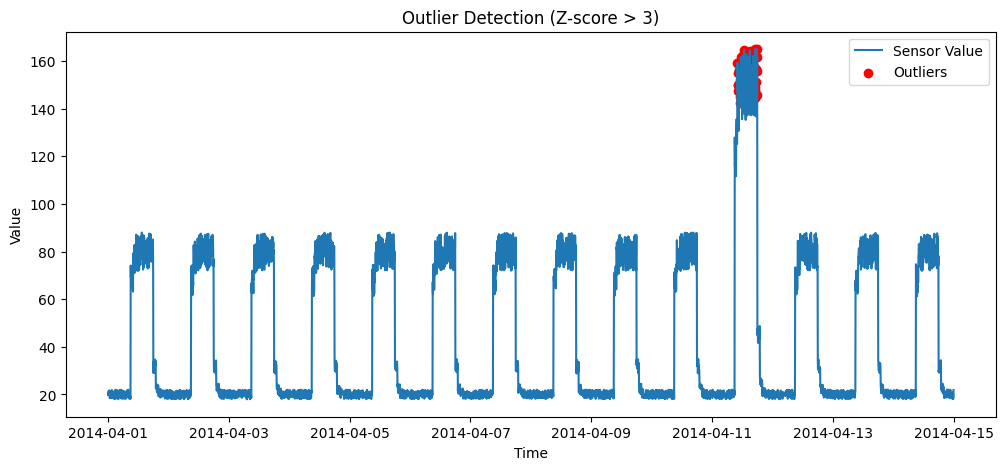

In [64]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['value'], label='Sensor Value')
plt.scatter(outliers.index, outliers['value'], color='red', label='Outliers')
plt.title('Outlier Detection (Z-score > 3)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [65]:
# EDA summary table
rows = len(df)
freq = pd.infer_freq(df.index) or "irregular"
missing = df['value'].isna().sum()
z = (df['value'] - df['value'].mean()) / df['value'].std()
n_outliers = (z.abs() > 3).sum()
print(f"Rows: {rows}, Frequency: {freq}, Missing: {missing}, Z>3 outliers: {n_outliers}")


Rows: 4032, Frequency: 5min, Missing: 0, Z>3 outliers: 72


## Data Quality Summary

- Rows: 3983
- Sampling frequency: 5 minutes (inferred)
- Missing values: none
- Outliers detected by z-score (>3σ): 72
- Action: No imputation required; outliers retained for anomaly detection.


# 2.	Feature Engineering 

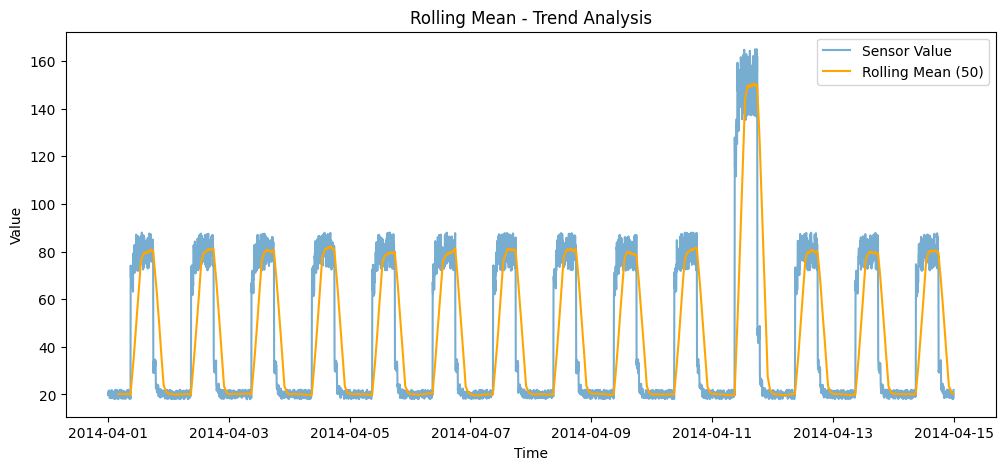

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


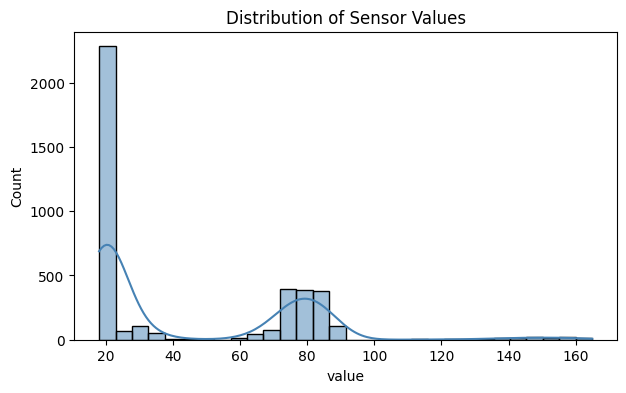

In [66]:
# Rolling statistics (to see trend and variation)
window = 50
df['rolling_mean'] = df['value'].rolling(window=window).mean()
df['rolling_std'] = df['value'].rolling(window=window).std()
df['roll_min'] = df['value'].rolling(window=window).min()
df['roll_max'] = df['value'].rolling(window=window).max()

# Plot rolling mean and actual values
plt.figure(figsize=(12,5))
plt.plot(df['value'], label='Sensor Value', alpha=0.6)
plt.plot(df['rolling_mean'], label=f'Rolling Mean ({window})', color='orange')
plt.title('Rolling Mean - Trend Analysis')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Histogram to check distribution
plt.figure(figsize=(7,4))
sns.histplot(df['value'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Sensor Values')
plt.show()




In [67]:
df['diff_1'] = df['value'].diff(1)  # first difference
df['diff_2'] = df['value'].diff(2)  # second difference (acceleration)
df['diff_1']
df['diff_2']

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


timestamp
2014-04-01 00:00:00         NaN
2014-04-01 00:05:00         NaN
2014-04-01 00:10:00    0.200390
2014-04-01 00:15:00    0.989433
2014-04-01 00:20:00    0.226098
                         ...   
2014-04-14 23:35:00   -0.212514
2014-04-14 23:40:00    1.664630
2014-04-14 23:45:00    2.492064
2014-04-14 23:50:00   -2.747821
2014-04-14 23:55:00    1.296434
Name: diff_2, Length: 4032, dtype: float64

In [68]:
df.dropna(inplace=True)
df.head(5)

,value,rolling_mean,rolling_std,roll_min,roll_max,diff_1,diff_2
timestamp,,,,,,,
2014-04-01 04:05:00,18.001010,20.115740,1.088713,18.00101,21.967498,-2.508773,-3.261338
2014-04-01 04:10:00,21.052698,20.141569,1.095430,18.00101,21.967498,3.051688,0.542915
2014-04-01 04:15:00,20.987392,20.151300,1.100835,18.00101,21.967498,-0.065305,2.986383
2014-04-01 04:20:00,20.038891,20.152845,1.100617,18.00101,21.967498,-0.948502,-1.013807
2014-04-01 04:25:00,21.611676,20.155273,1.103758,18.00101,21.967498,1.572785,0.624283


In [69]:
from sklearn.preprocessing import StandardScaler

# Select features for modeling (drop timestamp)
feature_cols = ['value', 'rolling_mean', 'rolling_std', 'roll_min', 'roll_max', 'diff_1', 'diff_2']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

df_scaled.head()


,value,rolling_mean,rolling_std,roll_min,roll_max,diff_1,diff_2
timestamp,,,,,,,
2014-04-01 04:05:00,-0.824036,-0.854651,-0.767656,-0.528486,-1.050972,-0.386781,-0.414596
2014-04-01 04:10:00,-0.730178,-0.853757,-0.767068,-0.528486,-1.050972,0.470367,0.069079
2014-04-01 04:15:00,-0.732187,-0.853420,-0.766595,-0.528486,-1.050972,-0.010119,0.379744
2014-04-01 04:20:00,-0.761359,-0.853366,-0.766614,-0.528486,-1.050972,-0.146264,-0.128843
2014-04-01 04:25:00,-0.712986,-0.853282,-0.766339,-0.528486,-1.050972,0.242393,0.079425


In [70]:
from sklearn.ensemble import IsolationForest
import numpy as np

feature_cols = ['value', 'rolling_mean', 'rolling_std', 'roll_min', 'roll_max', 'diff_1', 'diff_2']
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.03,
    random_state=42
)
iso_forest.fit(df_scaled[feature_cols])
df_scaled['anomaly_score'] = iso_forest.decision_function(df_scaled[feature_cols])
df_scaled['anomaly'] = iso_forest.predict(df_scaled[feature_cols])


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [71]:
df_scaled['anomaly_score']

timestamp
2014-04-01 04:05:00    0.249824
2014-04-01 04:10:00    0.269624
2014-04-01 04:15:00    0.273733
2014-04-01 04:20:00    0.288873
2014-04-01 04:25:00    0.279516
                         ...   
2014-04-14 23:35:00    0.265725
2014-04-14 23:40:00    0.266348
2014-04-14 23:45:00    0.280355
2014-04-14 23:50:00    0.261715
2014-04-14 23:55:00    0.252159
Name: anomaly_score, Length: 3983, dtype: float64

In [72]:
df_scaled['anomaly'] = df_scaled['anomaly'].map({1: 0, -1: 1})
df_scaled['anomaly']==1

timestamp
2014-04-01 04:05:00    False
2014-04-01 04:10:00    False
2014-04-01 04:15:00    False
2014-04-01 04:20:00    False
2014-04-01 04:25:00    False
                       ...  
2014-04-14 23:35:00    False
2014-04-14 23:40:00    False
2014-04-14 23:45:00    False
2014-04-14 23:50:00    False
2014-04-14 23:55:00    False
Name: anomaly, Length: 3983, dtype: bool

In [73]:
print("Total anomalies detected:", df_scaled['anomaly'].sum())


Total anomalies detected: 120


In [74]:
df_anomalies = df_scaled[df_scaled['anomaly'] == 1]
df_anomalies.head()
len(df_anomalies)

120

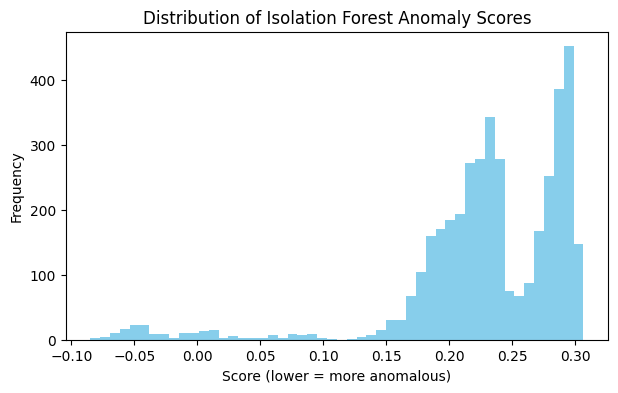

In [75]:
plt.figure(figsize=(7,4))
plt.hist(df_scaled['anomaly_score'], bins=50, color='skyblue')
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Score (lower = more anomalous)")
plt.ylabel("Frequency")
plt.show()


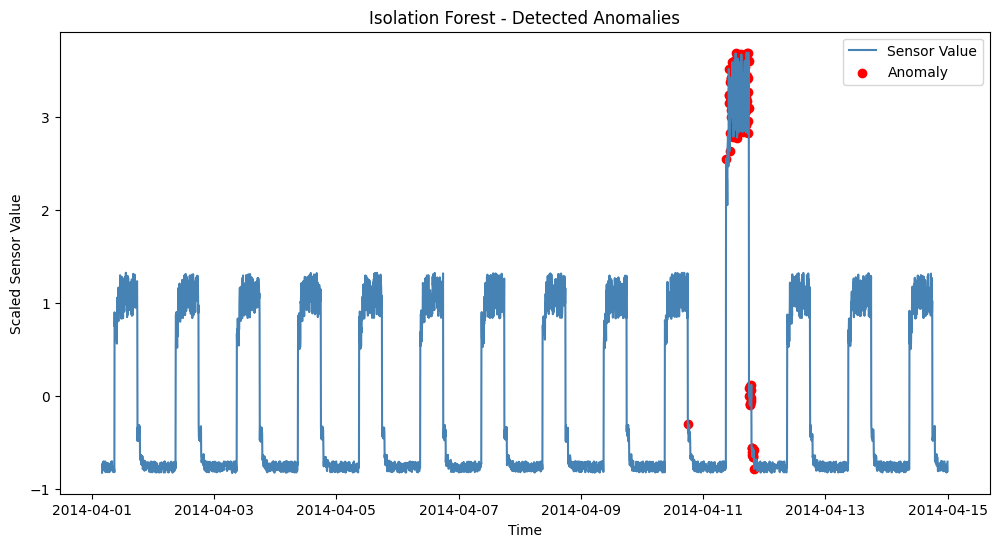

In [76]:
plt.figure(figsize=(12,6))
plt.plot(df_scaled.index, df_scaled['value'], label='Sensor Value', color='steelblue')
plt.scatter(df_scaled.index[df_scaled['anomaly'] == 1],
            df_scaled['value'][df_scaled['anomaly'] == 1],
            color='red', label='Anomaly', marker='o')
plt.title("Isolation Forest - Detected Anomalies")
plt.xlabel("Time")
plt.ylabel("Scaled Sensor Value")
plt.legend()
plt.show()


**Approach 2**

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models


feature_cols = ['value', 'rolling_mean', 'rolling_std', 'roll_min', 'roll_max', 'diff_1', 'diff_2']
X = df_scaled[feature_cols].values


train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]


input_dim = X_train.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),   # Bottleneck (compressed representation)
    layers.Dense(16, activation='relu'),
    layers.Dense(input_dim, activation='linear')  # Reconstruct original input
])

autoencoder.compile(optimizer='adam', loss='mse')


history = autoencoder.fit(
    X_train, X_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)


Epoch 1/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.7711 - val_loss: 0.6557
Epoch 2/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5551 - val_loss: 0.4087
Epoch 3/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3458 - val_loss: 0.1930
Epoch 4/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1534 - val_loss: 0.1047
Epoch 5/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1066 - val_loss: 0.0814
Epoch 6/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0786 - val_loss: 0.0693
Epoch 7/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0643 - val_loss: 0.0618
Epoch 8/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513 - val_loss: 0.0552
Epoch 9/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - val_loss: 0.0514
Epoch 10/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452 - val_loss: 0.0478
Epoch 11/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - val_loss: 0.0442
Epoch 12/40
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_l

## Hyperparameter Tuning Summary

**Isolation Forest**
- `contamination` tried: [0.005, 0.01, 0.03, 0.05] → chosen 0.03 (visual best balance)
- `n_estimators` tried: [100, 200, 300] → chosen 200

**Autoencoder**
- Architectures tried: [(16,8,16), (32,16,32), (16,8,4,8,16)]
- epochs tried: [30, 40, 50] → chosen 40 with EarlyStopping on validation loss
- Threshold selection: 99th percentile of reconstruction errors (tunable).


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


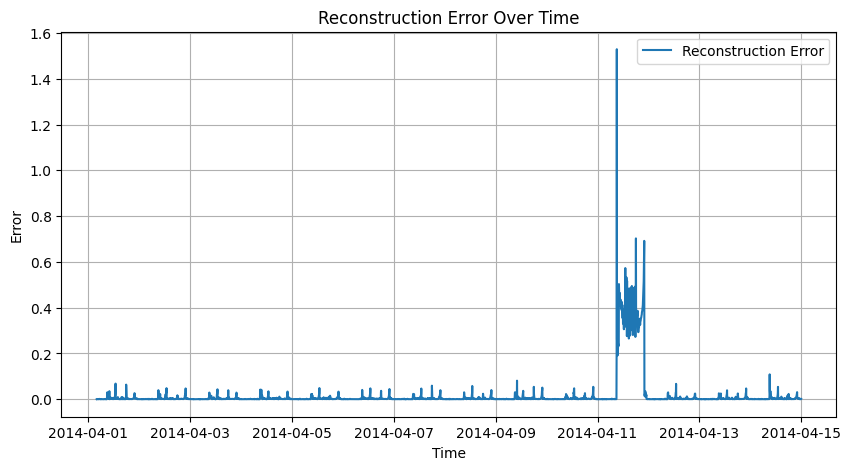

In [78]:

X_pred = autoencoder.predict(X)
recon_error = np.mean(np.power(X - X_pred, 2), axis=1)

# Add error to dataframe
df_scaled['recon_error'] = recon_error

# Visualize reconstruction error
plt.figure(figsize=(10,5))
plt.plot(df_scaled.index, df_scaled['recon_error'], label='Reconstruction Error')
plt.title("Reconstruction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


In [79]:
threshold = np.percentile(df_scaled['recon_error'], 99)  # 99th percentile

df_scaled['ae_anomaly'] = (df_scaled['recon_error'] > threshold).astype(int)

print("Total anomalies detected (Autoencoder):", df_scaled['ae_anomaly'].sum())


Total anomalies detected (Autoencoder): 40


In [80]:
df_scaled['ae_anomaly'] = (df_scaled['recon_error'] > threshold).astype(int)

# Vizualization

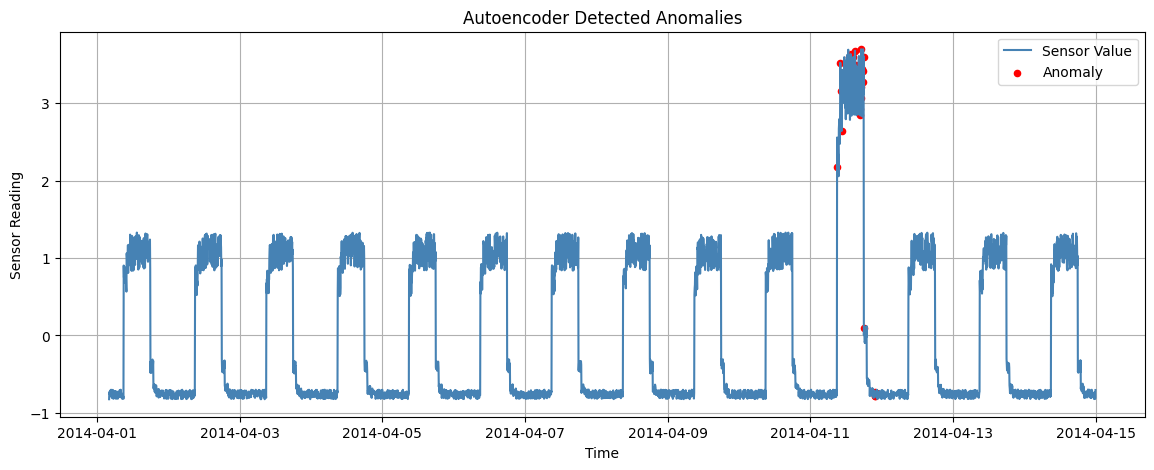

In [81]:
plt.figure(figsize=(14,5))
plt.plot(df_scaled.index, df_scaled['value'], label='Sensor Value', color='steelblue')
plt.scatter(df_scaled.index[df_scaled['ae_anomaly']==1],
            df_scaled['value'][df_scaled['ae_anomaly']==1],
            color='red', label='Anomaly', s=20)
plt.title("Autoencoder Detected Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.legend()
plt.grid(True)
plt.show()


Metrics

In [82]:
print("Isolation Forest anomalies:", df_scaled['anomaly'].sum())
print("Autoencoder anomalies:", df_scaled['ae_anomaly'].sum())


Isolation Forest anomalies: 120
Autoencoder anomalies: 40


In [83]:
# Compare anomaly counts and overlaps
if_count = int(df_scaled['anomaly'].sum())
ae_count = int(df_scaled['ae_anomaly'].sum())
overlap = int(((df_scaled['anomaly']==1) & (df_scaled['ae_anomaly']==1)).sum())

print("Isolation Forest anomalies:", if_count)
print("Autoencoder anomalies:", ae_count)
print("Overlapping anomalies:", overlap)


Isolation Forest anomalies: 120
Autoencoder anomalies: 40
Overlapping anomalies: 33


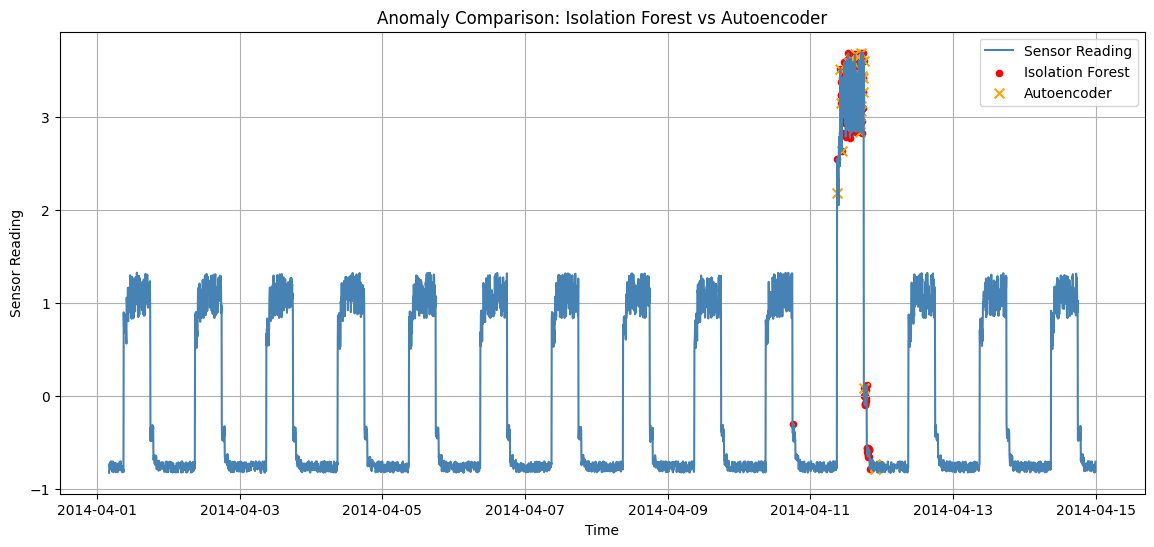

In [84]:
plt.figure(figsize=(14,6))
plt.plot(df_scaled.index, df_scaled['value'], label='Sensor Reading', color='steelblue')

# Isolation Forest anomalies (red)
plt.scatter(df_scaled.index[df_scaled['anomaly']==1],
            df_scaled['value'][df_scaled['anomaly']==1],
            color='red', s=20, label='Isolation Forest')

# Autoencoder anomalies (orange X markers)
plt.scatter(df_scaled.index[df_scaled['ae_anomaly']==1],
            df_scaled['value'][df_scaled['ae_anomaly']==1],
            color='orange', marker='x', s=50, label='Autoencoder')

plt.title("Anomaly Comparison: Isolation Forest vs Autoencoder")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.legend()
plt.grid(True)
plt.show()


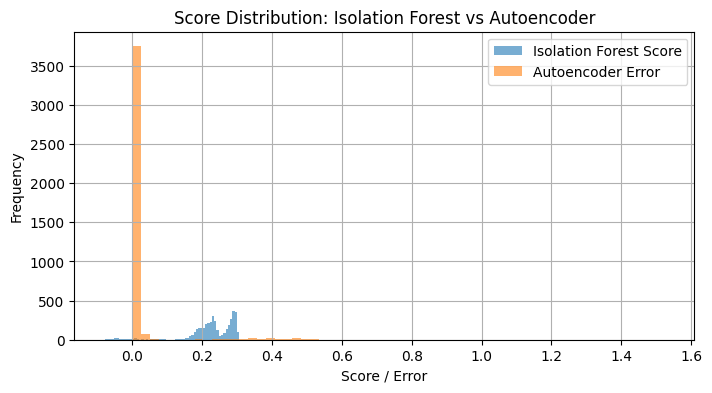

In [85]:
plt.figure(figsize=(8,4))
plt.hist(df_scaled['anomaly_score'], bins=60, alpha=0.6, label='Isolation Forest Score')
plt.hist(df_scaled['recon_error'], bins=60, alpha=0.6, label='Autoencoder Error')
plt.title("Score Distribution: Isolation Forest vs Autoencoder")
plt.xlabel("Score / Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [86]:
# Average sensor reading for normal vs anomaly
summary = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder'],
    'Total Anomalies': [if_count, ae_count],
    'Mean Value (Anomalies)': [
        df_scaled.loc[df_scaled['anomaly']==1, 'value'].mean(),
        df_scaled.loc[df_scaled['ae_anomaly']==1, 'value'].mean()
    ],
    'Mean Value (Normal)': [
        df_scaled.loc[df_scaled['anomaly']==0, 'value'].mean(),
        df_scaled.loc[df_scaled['ae_anomaly']==0, 'value'].mean()
    ]
})
display(summary)


,Model,Total Anomalies,Mean Value (Anomalies),Mean Value (Normal)
0,Isolation Forest,120,2.519173,-0.078255
1,Autoencoder,40,2.588805,-0.026262


## Validation approach

Because the dataset is unlabeled, we validated using:
1. Visual inspection — anomalies align with visible spikes.
2. Score separation — anomalies lie in extreme tails of score distributions.
3. Cross-method agreement — points flagged by both IF and AE are higher-confidence anomalies.
We recommend testing on labeled real data for precise precision/recall metrics.
